In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split


## Helper functions!

In [62]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [63]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

### Baseline Model for comparison

No change made to the data at all... no variables added or removed and no scaling applied

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42     # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# columns_to_scale = ['ATMs', 'Shops']
# scaler = StandardScaler().fit(train[columns_to_scale]) 

# train[columns_to_scale] = scaler.transform(train[columns_to_scale])
# test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train))
model.summary()

Test MSE:  6.202418293994368
Train MSE:  6.2675254081872716


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.934e+05
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:51:29   Log-Likelihood:                -41125.
No. Observations:               17600   AIC:                         8.226e+04
Df Residuals:                   17593   BIC:                         8.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4437      0.124     84.158      0.000      10.200      10.687
Shops          0.1079      0.001     97.890      0.000       0.106       0.110
ATMs          -1.0121      0.011    -96.011      0.000      -1.033      -0.991
Downtown     -35.9429      0.995    -36.113      0.000     -37.894     -33.992
Weekday       -3.5078      0.042    -83.871      0.000      -3.590      -3.426
Center         7.3074      0.063    116.366      0.000       7.184       7.431
High           0.9774      0.041     23.777      0.000       0.897       1.058
==============================================================================
Omnibus:                    13943.449   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353715.237
Skew:                           3.690   Prob(JB):                         0.00
Kurtosis:                      23.685   Cond. No.                     4.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [65]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

In [66]:
X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,974,10,1,1,0,0
2,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,958,9,1,1,0,1
4,0,0,0,0,0,103,4,0,1,0,1


## Run model with ALL the added input variables

This is an optional step so we can see the base line model results. We can examine the p variables to determine which variables should be excluded.

In [67]:
# Preprocess the data
# 1. Separate the data into training and test data
# 2. Fit the scaling to the training data and apply to both the train and test data 

# TO DO: Define columns to scale
columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X_new,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42     # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# 2. Scale
scaler = StandardScaler().fit(train[columns_to_scale]) 

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

train.head()


,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Shops,ATMs,Downtown,Weekday,Center,High
5207,63.505401,0.610189,1.221083,1,0,0,0.605054,1.379620,1,1,0,0
4450,16.843804,-1.523808,-1.430397,0,0,0,-1.511607,-1.606844,0,1,0,0
7033,15.024693,-1.523808,-1.430397,0,0,0,-1.516451,-1.335348,0,1,0,0
487,67.957098,0.658144,0.813163,1,0,0,0.658334,0.836626,1,1,0,0
19537,67.284580,0.627627,0.813163,1,0,0,0.624429,0.836626,1,1,0,0


In [68]:
# 3. Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  5.639878511435959
Train MSE:  5.50739963373822


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.823e+05
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:51:29   Log-Likelihood:                -39987.
No. Observations:               17600   AIC:                         8.000e+04
Df Residuals:                   17588   BIC:                         8.009e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      88.4603      0.867    102.089      0.000      86.762      90.159
Shops_DT       42.2703      2.985     14.159      0.000      36.419      48.122
ATMs_DT        -0.0957      0.162     -0.592      0.554      -0.412       0.221
Weekday__DT    -1.8550      0.085    -21.797      0.000      -2.022      -1.688
Center_DT       5.3657      0.128     41.916      0.000       5.115       5.617
High_DT        -0.0591      0.084     -0.703      0.482      -0.224       0.106
Shops           7.4912      2.652      2.825      0.005       2.293      12.689
ATMs           -3.6593      0.115    -31.782      0.000      -3.885      -3.434
Downtown      -46.4382      1.238    -37.505      0.000     -48.865     -44.011
Weekday        -2.2090      0.071    -31.158      0.000      -2.348      -2.070
Center          3.5630      0.107     33.361      0.000       3.354       3.772
High            1.0134      0.070     14.405      0.000       0.876       1.151
==============================================================================
Omnibus:                    10699.687   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201393.272
Skew:                           2.581   Prob(JB):                         0.00
Kurtosis:                      18.747   Cond. No.                         478.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: the MSE is already lower!

Looking at the p values, we should exclude variables `ATMs_DT` and `High_DT` from the model.


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [69]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1
        
        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 2048 iterations and 51.34 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=79994.71 with 10 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High

BIC=80070.64 with 9 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + ATMs + Downtown + Weekday + Center + High

test MSE: 5.64 has 11 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

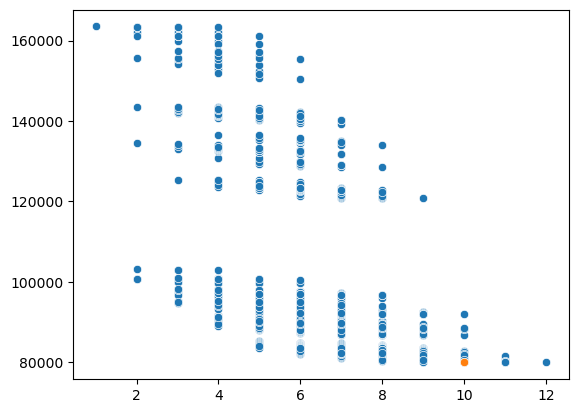

In [70]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

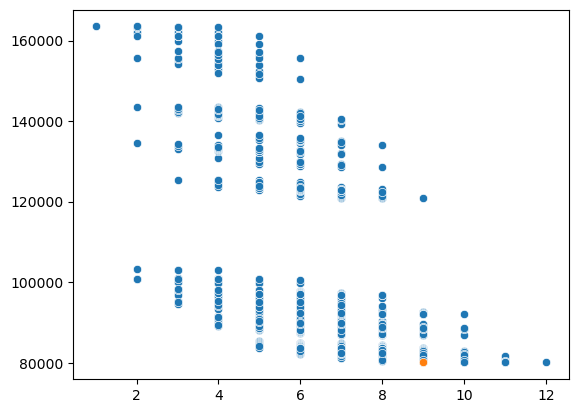

In [71]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

TypeError: unhashable type: 'list'

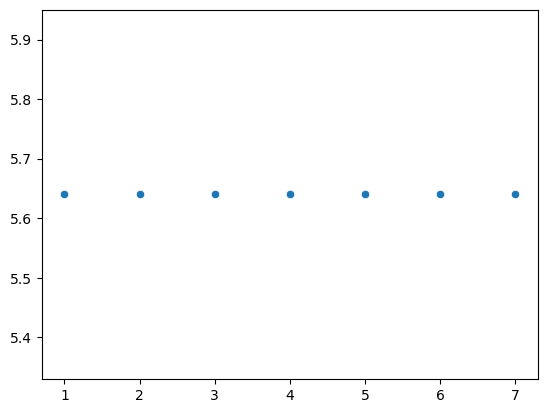

In [76]:
sns.scatterplot(x=range(1, len(X.columns) + 2),y=best_test_mse)
sns.scatterplot(x=[best_p_test], y=[test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

### TO DO: 

`from sklearn.feature_selection import RFECV`

Use this library to select features instead on cross validation

Note: I don't know how necessary this is given our time span. 
